## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

#### In all tables, assume:
* "➊" represents a single URL
* "➋" represents a single mention of a username (e.g. "@noah")
* "➌" represents a single mention of an English first name 

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from os.path import basename, splitext
from random import choice, sample
from nltk.corpus import stopwords
from string import punctuation
from pprint import pprint
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import scipy.stats
import itertools
import enchant
import nltk
import json
import re

#### Set up some regex patterns

In [3]:
urls_pattern = re.compile(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?\xab\xbb\u201c\u201d\u2018\u2019]))')

In [4]:
at_mentions_pattern = re.compile(r'(?<=^|(?<=[^a-zA-Z0-9-\.]))@([A-Za-z0-9_]+)')

In [5]:
names = open("../data/other_data/first_names.txt").read().split("\n")
names_pattern = re.compile(r'\b(?:{})\b'.format('|'.join(names)))

#### Prepare English dictionary for language detection

In [6]:
english_dict = enchant.Dict("en_US")

#### Use NLTK's tokenizer instead of Scikit's

In [7]:
tokenizer = nltk.casual.TweetTokenizer()

#### Prepare for viewing long text in CSVs and ones with really big and small numbers

In [8]:
pd.set_option("display.height", 1000)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("max_colwidth", 1000)

In [9]:
pd.options.display.float_format = "{:.4f}".format

#### Load the two data files
#### Only use tweets with at least 10% English words
#### Also, make the mentions of usernames, names, and URLs generic

In [10]:
def load_data(filename, threshold=0.1):
    data = [(urls_pattern.sub("➊", 
             at_mentions_pattern.sub("➋", 
             names_pattern.sub("➌",
             t["tweet_data"]["full_text"])))
             .replace("\u2018", "'")
             .replace("\u2019", "'")
             .replace("\u201c", "\"")
             .replace("\u201d", "\"")
             .replace("&quot;", "\"")
             .replace("&amp;", "&")
             .replace("&gt;", ">")
             .replace("&lt;", "<")) 
            for t in json.load(open(filename)) 
            if t["tweet_data"]["lang"] == "en" 
            and t["reply"]["lang"] == "en" 
            and t["tweet_data"]["user"]["lang"] == "en" 
            and t["reply"]["user"]["lang"] == "en"]
    new_data = []
    for tweet in data:
        tokens = tokenizer.tokenize(tweet)
        english_tokens = [english_dict.check(token) for token in tokens]
        percent_english_words = sum(english_tokens)/len(english_tokens)
        if percent_english_words >= threshold:
            new_data.append(tweet)
    return new_data

In [11]:
subtweets_data = load_data("../data/other_data/subtweets.json")

In [12]:
non_subtweets_data = load_data("../data/other_data/non_subtweets.json")

#### Remove tweets which are present in both datasets

In [13]:
subtweets_data = [tweet for tweet in subtweets_data if tweet not in non_subtweets_data]

In [14]:
non_subtweets_data = [tweet for tweet in non_subtweets_data if tweet not in subtweets_data]

#### Show examples

In [15]:
print("Subtweets dataset example:")
print(choice(subtweets_data))

Subtweets dataset example:
True friends stab you in the front 🤘🏽


In [16]:
print("Non-subtweets dataset example:")
print(choice(non_subtweets_data))

Non-subtweets dataset example:
Congratulations to our nurses at North Shore University Hospital for earning Magnet status – the gold standard for #nursing excellence – by ➋! ➊


#### Find the length of the smaller dataset

In [17]:
smallest_length = len(min([subtweets_data, non_subtweets_data], key=len))

#### Cut both down to be the same length

In [18]:
subtweets_data = sample(subtweets_data, smallest_length)

In [19]:
non_subtweets_data = sample(non_subtweets_data, smallest_length)

In [20]:
print("Smallest dataset length: {}".format(len(subtweets_data)))

Smallest dataset length: 11288


#### Prepare data for training

In [21]:
subtweets_data = [(tweet, "subtweet") for tweet in subtweets_data]

In [22]:
non_subtweets_data = [(tweet, "non-subtweet") for tweet in non_subtweets_data]

#### Combine them

In [23]:
training_data = subtweets_data + non_subtweets_data

#### Build the pipeline

In [24]:
sentiment_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   ngram_range=(1, 3), 
                                   stop_words="english")),
    ("classifier", MultinomialNB())
])

#### K-Folds splits up and separates out 10 training and test sets from the data, from which the classifier is trained and the confusion matrix and classification reports are updated

In [25]:
def confusion_matrices(training_data, num_folds=10):
    text_training_data = np.array([row[0] for row in training_data])
    class_training_data = np.array([row[1] for row in training_data])
    kf = KFold(n_splits=num_folds, random_state=42, shuffle=True)
    
    cnf_matrix_test = np.zeros((2, 2), dtype=int)
    cnf_matrix_train = np.zeros((2, 2), dtype=int)
    
    test_reports = []
    train_reports = []
    
    test_accuracies = []
    train_accuracies = []
    for i, (train_index, test_index) in enumerate(kf.split(text_training_data)):

        text_train, text_test = text_training_data[train_index], text_training_data[test_index]
        class_train, class_test = class_training_data[train_index], class_training_data[test_index]

        sentiment_pipeline.fit(text_train, class_train)
        
        predictions_test = sentiment_pipeline.predict(text_test)
        predictions_train = sentiment_pipeline.predict(text_train)

        cnf_matrix_test += confusion_matrix(class_test, predictions_test)
        cnf_matrix_train += confusion_matrix(class_train, predictions_train)

        print("Test Data Iteration {}:".format(i+1))
        
        test_report = classification_report(class_test, predictions_test, digits=4)
        test_reports.append(test_report)
        print(test_report)
                
        test_accuracy = accuracy_score(class_test, predictions_test)
        test_accuracies.append(test_accuracy)
        print("Test Data Accuracy: {:.4f}\n".format(test_accuracy))
        print("="*53)
        
        print("Train Data Iteration {}:".format(i+1))
        
        train_report = classification_report(class_train, predictions_train, digits=4)
        train_reports.append(train_report)
        print(train_report)
                
        train_accuracy = accuracy_score(class_train, predictions_train)
        train_accuracies.append(train_accuracy)
        print("Train Data Accuracy: {:.4f}\n".format(train_accuracy))
        print("="*53)
        
    def reports_mean(reports):
        reports_lists_of_strings = [report.split("\n") for report in reports]
        reports = [[[float(e) for e in report_string[2][16:].split()],
                    [float(e) for e in report_string[3][16:].split()],
                    [float(e) for e in report_string[5][16:].split()]]
                   for report_string in reports_lists_of_strings]
        mean_list = np.mean(np.array(reports), axis=0).tolist()
        print("              precision    recall  f1-score   support")
        print()
        print("non-subtweet     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[0][0], 
                                                                                 mean_list[0][1], 
                                                                                 mean_list[0][2], 
                                                                                 int(mean_list[0][3])))
        print("    subtweet     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[1][0], 
                                                                                 mean_list[1][1], 
                                                                                 mean_list[1][2], 
                                                                                 int(mean_list[1][3])))
        print()
        print(" avg / total     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[2][0], 
                                                                                 mean_list[2][1], 
                                                                                 mean_list[2][2], 
                                                                                 int(mean_list[2][3])))
        print()
        print("="*53)
    
    print("Test Data Averages Across All Folds:")
    reports_mean(test_reports)
    
    print("Train Data Averages Across All Folds:")
    reports_mean(train_reports)
    
    return {"Test": cnf_matrix_test, "Train": cnf_matrix_train}

In [26]:
cnf_matrices = confusion_matrices(training_data)
cnf_matrix_test = cnf_matrices["Test"]
cnf_matrix_train = cnf_matrices["Train"]

Test Data Iteration 1:
              precision    recall  f1-score   support

non-subtweet     0.7176    0.7222    0.7199      1087
    subtweet     0.7405    0.7361    0.7383      1171

 avg / total     0.7295    0.7294    0.7294      2258

Test Data Accuracy: 0.7294

Train Data Iteration 1:
              precision    recall  f1-score   support

non-subtweet     0.9796    0.9856    0.9826     10201
    subtweet     0.9854    0.9793    0.9824     10117

 avg / total     0.9825    0.9825    0.9825     20318

Train Data Accuracy: 0.9825

Test Data Iteration 2:
              precision    recall  f1-score   support

non-subtweet     0.7053    0.7008    0.7030      1103
    subtweet     0.7160    0.7203    0.7182      1155

 avg / total     0.7108    0.7108    0.7108      2258

Test Data Accuracy: 0.7108

Train Data Iteration 2:
              precision    recall  f1-score   support

non-subtweet     0.9805    0.9858    0.9831     10185
    subtweet     0.9856    0.9803    0.9829     10133



#### See the most informative features
[How does "MultinomialNB.coef_" work?](https://stackoverflow.com/a/29915740/6147528)

In [27]:
def most_informative_features(pipeline, n=15000):
    vectorizer = pipeline.named_steps["vectorizer"]
    classifier = pipeline.named_steps["classifier"]
    
    class_labels = classifier.classes_
    
    feature_names = vectorizer.get_feature_names()
    
    top_n_class_1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    top_n_class_2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
    
    return {class_labels[0]: pd.DataFrame({"Log Probability": [tup[0] for tup in top_n_class_1], 
                                           "Feature": [tup[1] for tup in top_n_class_1]}), 
            class_labels[1]: pd.DataFrame({"Log Probability": [tup[0] for tup in reversed(top_n_class_2)],
                                           "Feature": [tup[1] for tup in reversed(top_n_class_2)]})}

In [28]:
most_informative_features_all = most_informative_features(sentiment_pipeline)

In [29]:
most_informative_features_non_subtweet = most_informative_features_all["non-subtweet"]

In [30]:
most_informative_features_subtweet = most_informative_features_all["subtweet"]

In [31]:
final_features = most_informative_features_non_subtweet.join(most_informative_features_subtweet, 
                                                             lsuffix=" (Non-subtweet)", 
                                                             rsuffix=" (Subtweet)")
final_features.to_csv("../data/other_data/most_informative_features.csv")
final_features.head(50)

,Feature (Non-subtweet),Log Probability (Non-subtweet),Feature (Subtweet),Log Probability (Subtweet)
0,! ! #absapremiership,-13.0545,.,-7.6448
1,! ! #bbnaija,-13.0545,",",-8.0039
2,! ! #cholecystectomy,-13.0545,➊,-8.0539
3,! ! #happyeasterfromhell,-13.0545,"""",-8.1549
4,! ! #liars,-13.0545,people,-8.4268
5,! ! #manila,-13.0545,?,-8.5501
6,! ! #meekotw,-13.0545,like,-8.6645
7,! ! #newprofilepic,-13.0545,don't,-8.6859
8,! ! #nintendoswitch,-13.0545,just,-8.7385
9,! ! #nraisaterroristorganzation,-13.0545,i'm,-8.8133


#### Define function for visualizing confusion matrices

In [32]:
def plot_confusion_matrix(cm, classes=["non-subtweet", "subtweet"], 
                          title="Confusion Matrix", cmap=plt.cm.Purples):
    
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    
    plt.title(title, size=18)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{} ({:.0%})".format(cm[i, j], cm_normalized[i, j]),
                horizontalalignment="center", size=16,
                color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    
    plt.ylabel("True label", fontsize=14)
    plt.xlabel("Predicted Label", fontsize=14)

#### Show the matrices

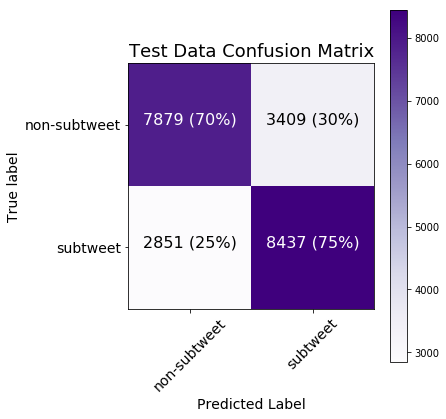

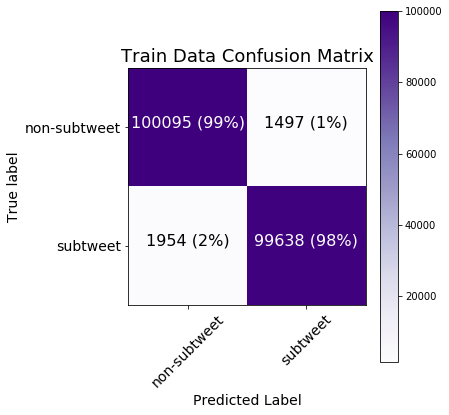

In [33]:
np.set_printoptions(precision=2)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix_test, title="Test Data Confusion Matrix")

plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix_train, title="Train Data Confusion Matrix")

plt.show()

#### Update matplotlib style

In [34]:
plt.style.use("fivethirtyeight")

#### Save the classifier for another time

In [35]:
joblib.dump(sentiment_pipeline, "../data/other_data/subtweets_classifier.pkl");

#### Print tests for the classifier

In [36]:
def process_tweets_for_testing(filenames):
    dataframes = {}
    for filename in filenames:
        username = splitext(basename(filename))[0][:-7]
        dataframes[username] = {}
        
        user_df = pd.read_csv(filename).dropna()
        user_df["Text"] = user_df["Text"].str.replace(urls_pattern, "➊")
        user_df["Text"] = user_df["Text"].str.replace(at_mentions_pattern, "➋")
        user_df["Text"] = user_df["Text"].str.replace(names_pattern, "➌")
        user_df["Text"] = user_df["Text"].str.replace("\u2018", "'")
        user_df["Text"] = user_df["Text"].str.replace("\u2019", "'")
        user_df["Text"] = user_df["Text"].str.replace("\u201c", "\"")
        user_df["Text"] = user_df["Text"].str.replace("\u201d", "\"")
        user_df["Text"] = user_df["Text"].str.replace("&quot;", "\"")
        user_df["Text"] = user_df["Text"].str.replace("&amp;", "&")
        user_df["Text"] = user_df["Text"].str.replace("&gt;", ">")
        user_df["Text"] = user_df["Text"].str.replace("&lt;", "<")
        
        predictions = sentiment_pipeline.predict_proba(user_df["Text"])[:, 1].tolist()
        user_df["SubtweetProbability"] = predictions

        dataframes[username]["all"] = user_df
        
        scores = user_df[["SubtweetProbability"]].rename(columns={"SubtweetProbability": username})
        
        dataframes[username]["scores"] = scores
        dataframes[username]["stats"] = scores.describe()
        
    return dataframes

#### Load the CSV files

In [37]:
filenames = glob("../data/data_for_testing/friends_data/*.csv")

In [38]:
dataframes = process_tweets_for_testing(filenames)

#### Show a random table

In [39]:
chosen_username = choice(list(dataframes.keys()))
dataframes[chosen_username]["all"].sort_values(by="SubtweetProbability", ascending=False).head(5)

,Text,Date,Favorites,Retweets,Tweet ID,SubtweetProbability
753,no offense but there are maybe like two people who are not annoying on social media,2018-01-11 15:00:31,2,0,951544369068347392,0.8710
803,the fact that twitter shows tweets people you follow have liked means that sub-liking is also a thing,2018-01-10 16:56:58,6,0,951211288046301184,0.8671
751,I think u and I both know that we're both annoying bc we complain way too much,2018-01-11 15:01:50,1,0,951544701798305792,0.8609
886,angery tweets targeted at a specific person or group of people without directly mentioning the target,2017-12-27 18:08:54,2,0,946155959679967234,0.8578
288,i don't trust people who can,2018-02-04 21:39:26,0,0,960342070723571713,0.8356


#### Prepare statistics on tweets

In [40]:
test_df = pd.concat([df_dict["scores"] for df_dict in dataframes.values()], ignore_index=True)

In [41]:
test_df_stats = test_df.count()

#### Total number of tweets per account:

In [42]:
test_df_stats

akrapf96           2640
generatedtext      2066
gothodile          3488
juliaeberry        4356
kayleesue          1939
keithohara         1169
noahsegalgould     2814
pumpkinheadgal      772
scorpiodisaster    5364
whoisleormiller     853
zoeterhune         1467
dtype: int64

In [43]:
test_df_over = test_df[test_df >= 0.5]

In [44]:
test_df_over_stats = test_df_over.count()

#### Total number of classified subtweets (>= 50%) per account

In [45]:
test_df_over_stats

akrapf96           1453
generatedtext      1460
gothodile          1987
juliaeberry        2652
kayleesue           942
keithohara          334
noahsegalgould     1577
pumpkinheadgal      517
scorpiodisaster    2918
whoisleormiller     578
zoeterhune          956
dtype: int64

In [46]:
test_df_combined = pd.concat([test_df_over_stats, test_df_stats], axis=1)

In [47]:
test_df_combined.columns = ["subtweets", "total_tweets"]

In [48]:
test_df_combined["percent_subtweets"] = test_df_combined["subtweets"]/test_df_combined["total_tweets"]

In [49]:
test_df_combined.sort_values(by="percent_subtweets", inplace=True)

#### Overall stats

In [50]:
test_df_combined

,subtweets,total_tweets,percent_subtweets
keithohara,334,1169,0.2857
kayleesue,942,1939,0.4858
scorpiodisaster,2918,5364,0.5440
akrapf96,1453,2640,0.5504
noahsegalgould,1577,2814,0.5604
gothodile,1987,3488,0.5697
juliaeberry,2652,4356,0.6088
zoeterhune,956,1467,0.6517
pumpkinheadgal,517,772,0.6697
whoisleormiller,578,853,0.6776


#### Min subtweeter

In [51]:
min_sub = (test_df_combined.loc[test_df_combined.percent_subtweets==test_df_combined.percent_subtweets.min()]
           .transpose())

In [52]:
min_sub

,keithohara
subtweets,334.0000
total_tweets,1169.0000
percent_subtweets,0.2857


In [53]:
min_name = min_sub.columns[0]

#### Median subtweeter

In [54]:
med_sub = (test_df_combined.loc[test_df_combined.percent_subtweets==test_df_combined.percent_subtweets.median()]
           .transpose())

In [55]:
med_sub

,gothodile
subtweets,1987.0000
total_tweets,3488.0000
percent_subtweets,0.5697


In [56]:
med_name = med_sub.columns[0]

#### Maximum subtweeter

In [57]:
max_sub = (test_df_combined.loc[test_df_combined.percent_subtweets==test_df_combined.percent_subtweets.max()]
           .transpose())

In [58]:
max_sub

,generatedtext
subtweets,1460.0000
total_tweets,2066.0000
percent_subtweets,0.7067


In [59]:
max_name = max_sub.columns[0]

#### Plot a histogram with three random users

[0.43124774187297815, 0.11470247621812371]
[0.5181890043086139, 0.12907908918041683]
[0.5625465100894748, 0.12051928373485082]


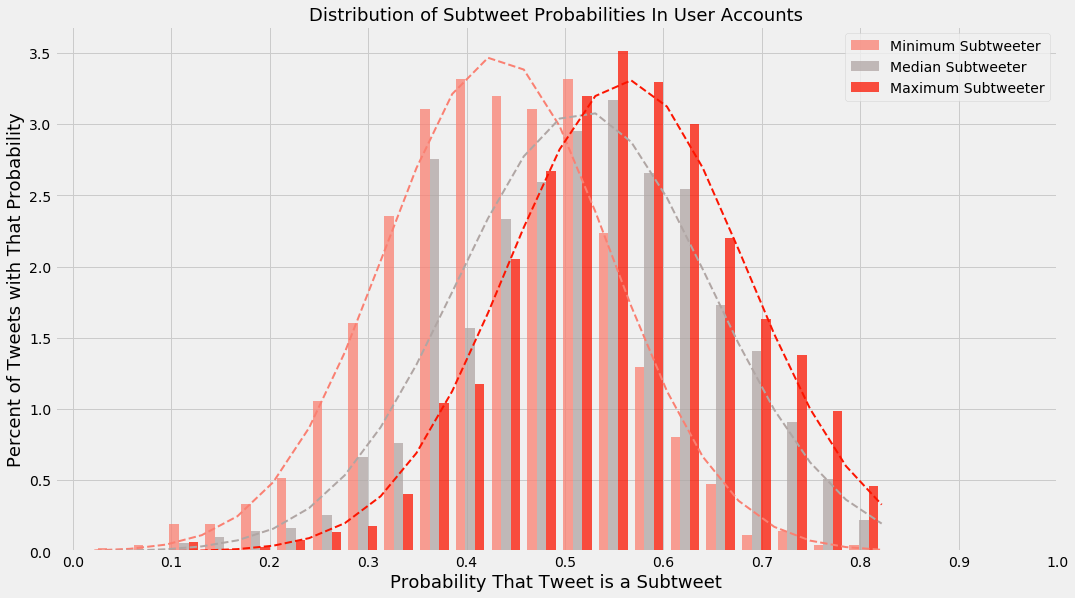

In [60]:
choices = [dataframes[min_name], dataframes[med_name], dataframes[max_name]]
scores = [df_dict["scores"][df_dict["scores"].columns[0]].tolist() 
          for df_dict in choices]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(scores, 
                           bins="scott",
                           color=["#FA8072", "#B0A6A4", "#FC1501"],
                           density=True, 
                           label=["Minimum Subtweeter", "Median Subtweeter", "Maximum Subtweeter"],
                           alpha=0.75)

stats = [df_dict["stats"][df_dict["stats"].columns[0]].tolist() 
         for df_dict in choices]
for e in stats:
    print(e[1:3])
line_1 = scipy.stats.norm.pdf(bins, stats[0][1], stats[0][2])
ax.plot(bins, line_1, "--", color="#FA8072", linewidth=2)

line_2 = scipy.stats.norm.pdf(bins, stats[1][1], stats[1][2])
ax.plot(bins, line_2, "--", color="#B0A6A4", linewidth=2)

line_3 = scipy.stats.norm.pdf(bins, stats[2][1], stats[2][2])
ax.plot(bins, line_3, "--", color="#FC1501", linewidth=2)

ax.set_xticks([float(x/10) for x in range(11)], minor=False)
ax.set_title("Distribution of Subtweet Probabilities In User Accounts", fontsize=18)
ax.set_xlabel("Probability That Tweet is a Subtweet", fontsize=18)
ax.set_ylabel("Percent of Tweets with That Probability", fontsize=18)

ax.legend()

plt.show()

#### Plot a histogram with all of them
#### First, get some statistics

In [61]:
new_tests_df = pd.concat([df_dict["scores"].rename(columns={df_dict["scores"].columns[0]:"SubtweetProbability"})
                          for df_dict in dataframes.values()], ignore_index=True)

new_tests_df_stats = new_tests_df.describe()

#### Then view them

In [62]:
new_tests_df.describe()

,SubtweetProbability
count,26928.0000
mean,0.5172
std,0.1262
min,0.0219
25%,0.4360
50%,0.5191
75%,0.6008
max,0.9537


#### Now plot

No handles with labels found to put in legend.


0.5172188068814326
0.12617331042417565


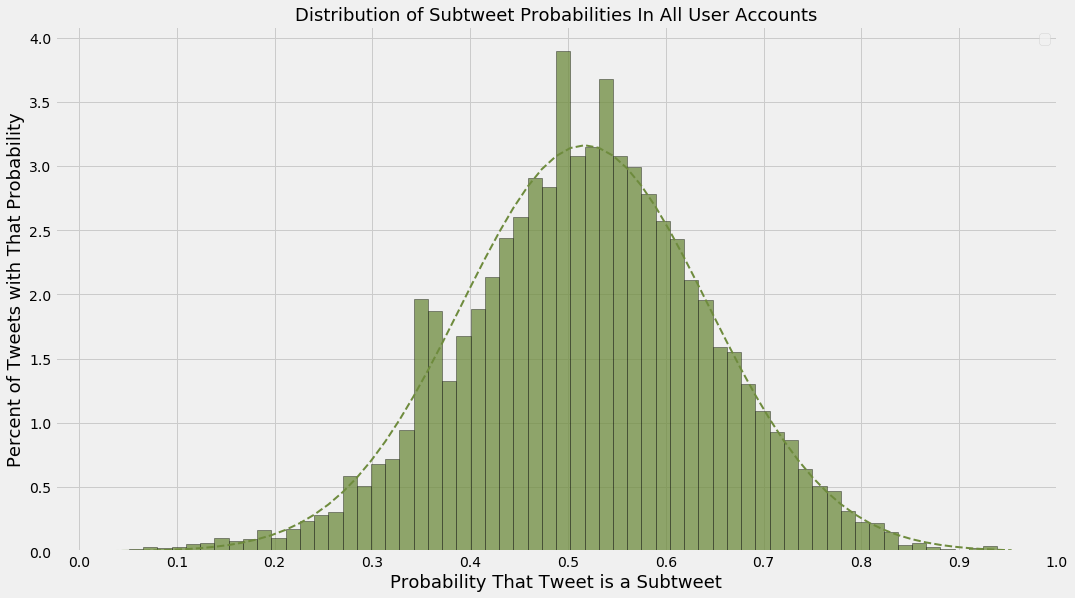

In [63]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(new_tests_df["SubtweetProbability"].tolist(), 
                           bins="scott",
                           color="#6E8B3D",
                           edgecolor="black", 
                           density=True, 
                           alpha=0.75)
print(new_tests_df_stats["SubtweetProbability"][1])
print(new_tests_df_stats["SubtweetProbability"][2])
line = scipy.stats.norm.pdf(bins, new_tests_df_stats["SubtweetProbability"][1], 
                            new_tests_df_stats["SubtweetProbability"][2])

ax.plot(bins, line, "--", color="#6E8B3D", linewidth=2)


ax.set_xticks([float(x/10) for x in range(11)], minor=False)
ax.set_title("Distribution of Subtweet Probabilities In All User Accounts", fontsize=18)
ax.set_xlabel("Probability That Tweet is a Subtweet", fontsize=18)
ax.set_ylabel("Percent of Tweets with That Probability", fontsize=18)

ax.legend()

plt.show()

#### Statisitics on training data

#### Remove generic tokens for these statistics

In [64]:
subtweets_data = [tweet[0] for tweet in subtweets_data]
non_subtweets_data = [tweet[0] for tweet in non_subtweets_data]

#### Lengths

In [65]:
length_data_subtweets = [len(tweet) for tweet in subtweets_data]
length_data_non_subtweets = [len(tweet) for tweet in non_subtweets_data]

In [66]:
length_data_for_stats_subtweets = pd.DataFrame({"Length": length_data_subtweets, 
                                                "Tweet": subtweets_data})
length_data_for_stats_non_subtweets = pd.DataFrame({"Length": length_data_non_subtweets, 
                                                    "Tweet": non_subtweets_data})

#### Tweet length statistics

In [67]:
length_data_for_stats_subtweets.describe()

,Length
count,11288.0000
mean,103.7098
std,71.9859
min,4.0000
25%,47.0000
50%,84.0000
75%,143.0000
max,282.0000


In [68]:
length_data_for_stats_non_subtweets.describe()

,Length
count,11288.0000
mean,104.9724
std,74.8360
min,5.0000
25%,45.0000
50%,84.0000
75%,149.0000
max,343.0000


#### Punctuation

In [69]:
punctuation_data_subtweets = [len(set(punctuation).intersection(set(tweet))) 
                              for tweet in subtweets_data]
punctuation_data_non_subtweets = [len(set(punctuation).intersection(set(tweet))) 
                                  for tweet in non_subtweets_data]

In [70]:
punctuation_data_for_stats_subtweets = pd.DataFrame({"Punctuation": punctuation_data_subtweets, 
                                                     "Tweet": subtweets_data})
punctuation_data_for_stats_non_subtweets = pd.DataFrame({"Punctuation": punctuation_data_non_subtweets, 
                                                         "Tweet": non_subtweets_data})

In [71]:
punctuation_data_for_stats_subtweets.describe()

,Punctuation
count,11288.0000
mean,1.7892
std,1.5407
min,0.0000
25%,1.0000
50%,2.0000
75%,3.0000
max,13.0000


In [72]:
punctuation_data_for_stats_non_subtweets.describe()

,Punctuation
count,11288.0000
mean,2.1615
std,1.6928
min,0.0000
25%,1.0000
50%,2.0000
75%,3.0000
max,11.0000


#### Stop words

In [73]:
stop_words_data_subtweets = [len(set(stopwords.words("english")).intersection(set(tweet.lower()))) 
                             for tweet in subtweets_data]
stop_words_data_non_subtweets = [len(set(stopwords.words("english")).intersection(set(tweet.lower()))) 
                                 for tweet in non_subtweets_data]

In [74]:
stop_words_data_for_stats_subtweets = pd.DataFrame({"Stop words": stop_words_data_subtweets, 
                                                    "Tweet": subtweets_data})
stop_words_data_for_stats_non_subtweets = pd.DataFrame({"Stop words": stop_words_data_non_subtweets, 
                                                        "Tweet": non_subtweets_data})

#### Tweets stop words statistics

In [75]:
stop_words_data_for_stats_subtweets.describe()

,Stop words
count,11288.0000
mean,7.1411
std,1.3108
min,0.0000
25%,7.0000
50%,8.0000
75%,8.0000
max,8.0000


In [76]:
stop_words_data_for_stats_non_subtweets.describe()

,Stop words
count,11288.0000
mean,7.0456
std,1.3925
min,0.0000
25%,7.0000
50%,8.0000
75%,8.0000
max,8.0000


#### Unique words

In [77]:
unique_words_data_subtweets = [sum([english_dict.check(token) 
                                    for token in set(tokenizer.tokenize(tweet))]) 
                               for tweet in subtweets_data]
unique_words_data_non_subtweets = [sum([english_dict.check(token) 
                                        for token in set(tokenizer.tokenize(tweet))]) 
                                   for tweet in non_subtweets_data]

In [78]:
unique_words_data_for_stats_subtweets = pd.DataFrame({"Unique words": unique_words_data_subtweets, 
                                                      "Tweet": subtweets_data})
unique_words_data_for_stats_non_subtweets = pd.DataFrame({"Unique words": unique_words_data_non_subtweets, 
                                                          "Tweet": non_subtweets_data})

#### Tweets unique words statistics

In [79]:
unique_words_data_for_stats_subtweets.describe()

,Unique words
count,11288.0000
mean,16.7966
std,10.9451
min,1.0000
25%,8.0000
50%,14.0000
75%,23.0000
max,55.0000


In [80]:
unique_words_data_for_stats_non_subtweets.describe()

,Unique words
count,11288.0000
mean,16.1331
std,11.1662
min,1.0000
25%,7.0000
50%,13.0000
75%,23.0000
max,50.0000


#### Plot them

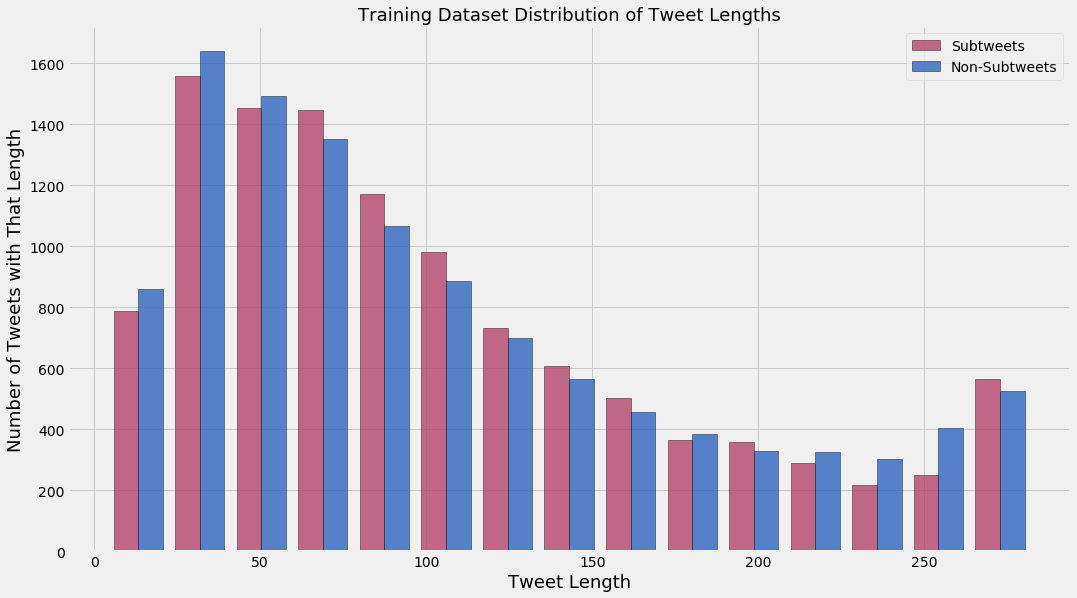

In [81]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist([length_data_subtweets, length_data_non_subtweets], 
                           bins="sturges", 
                           edgecolor="black", 
                           color=["#B4436C", "#3066BE"],
                           alpha=0.8)
ax.legend(["Subtweets", "Non-Subtweets"], loc="best")
ax.set_title("Training Dataset Distribution of Tweet Lengths", fontsize=18)
ax.set_xlabel("Tweet Length", fontsize=18);
ax.set_ylabel("Number of Tweets with That Length", fontsize=18);

plt.show()

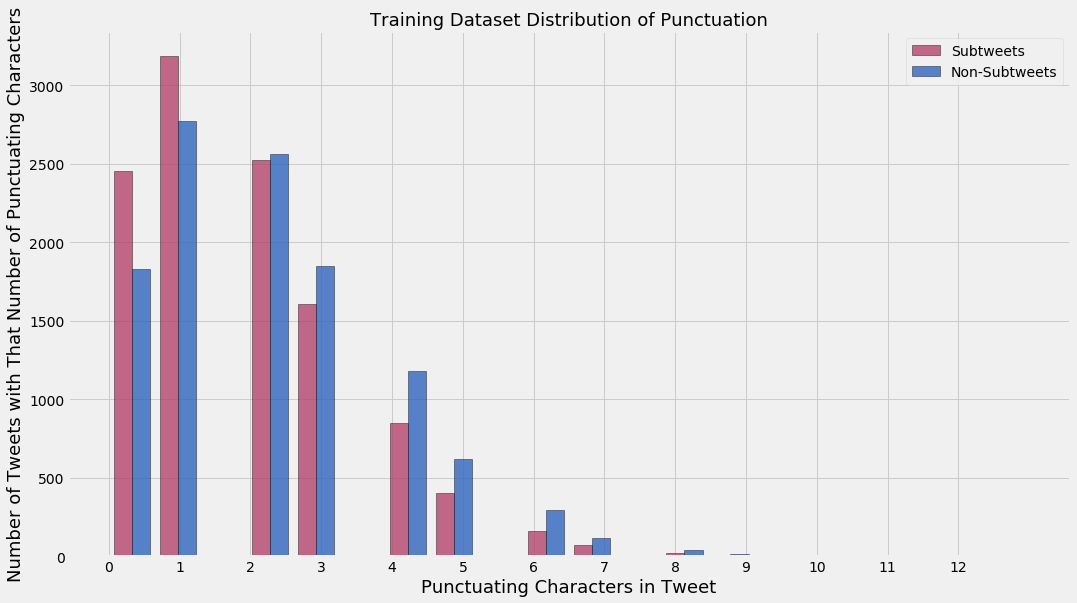

In [82]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist([punctuation_data_subtweets, punctuation_data_non_subtweets], 
                           bins="doane", 
                           edgecolor="black", 
                           color=["#B4436C", "#3066BE"],
                           alpha=0.8)
ax.set_xticks(np.arange(0, 13, step=1))
ax.legend(["Subtweets", "Non-Subtweets"], loc="best")
ax.set_title("Training Dataset Distribution of Punctuation", fontsize=18)
ax.set_xlabel("Punctuating Characters in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Punctuating Characters", fontsize=18)

plt.show()

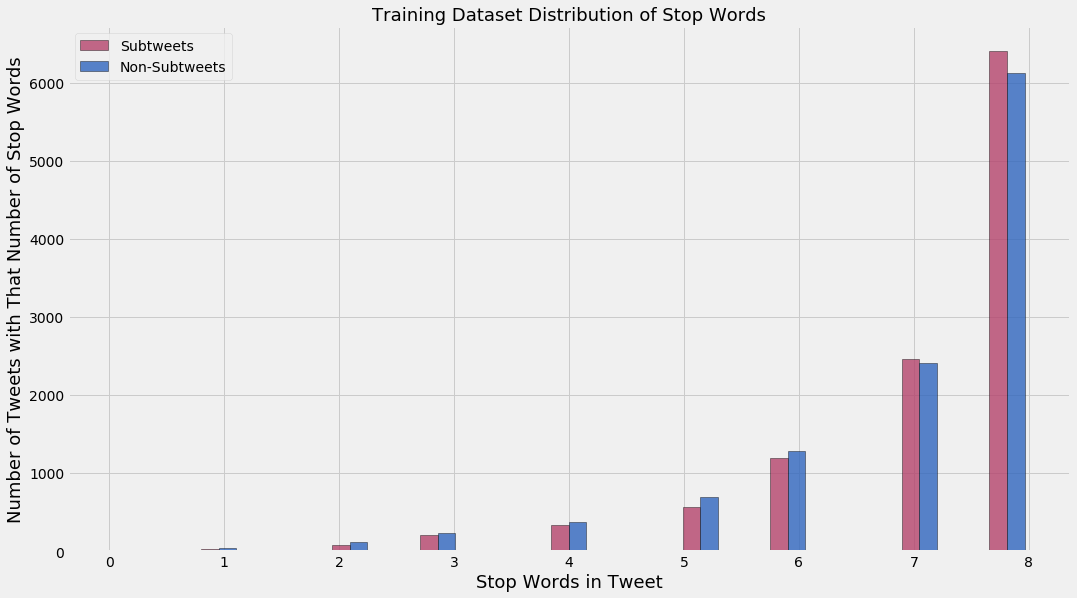

In [83]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist([stop_words_data_subtweets, stop_words_data_non_subtweets], 
                           bins="doane", 
                           edgecolor="black", 
                           color=["#B4436C", "#3066BE"],
                           alpha=0.8)

ax.legend(["Subtweets", "Non-Subtweets"], loc="best")
ax.set_title("Training Dataset Distribution of Stop Words", fontsize=18)
ax.set_xlabel("Stop Words in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Stop Words", fontsize=18)

plt.show()

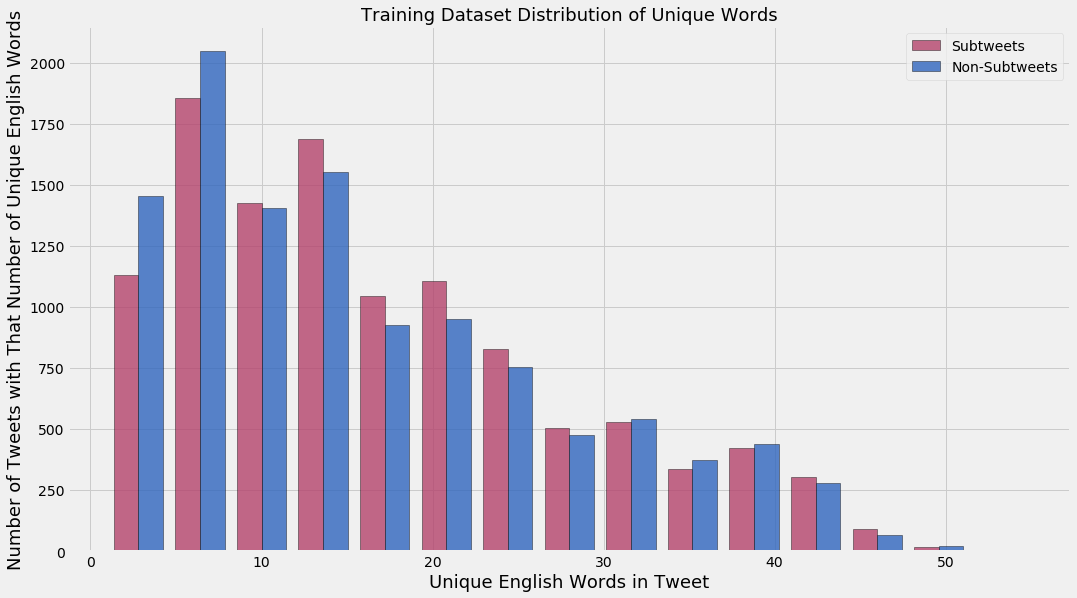

In [84]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist([unique_words_data_subtweets, unique_words_data_non_subtweets], 
                           bins="sturges", 
                           edgecolor="black", 
                           color=["#B4436C", "#3066BE"],
                           alpha=0.8)

ax.legend(["Subtweets", "Non-Subtweets"], loc="best")
ax.set_title("Training Dataset Distribution of Unique Words", fontsize=18)
ax.set_xlabel("Unique English Words in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Unique English Words", fontsize=18)

plt.show()